# CS584 Homework 5: Machine Translation

# Seq2Seq: GRU

* English to French

## 1. Data preparation¶


In [1]:
import re
import string
from unicodedata import normalize
import numpy as np

In [2]:
"""
load_doc: loading file 
to_line: cutting the the whole file to line by line
clean_data: remove the symble, url, or other irrevalent information 

"""

def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

def to_line(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return lines

def clean_data(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # normalize unicode characters
        line = normalize('NFD', line).encode('utf-8', 'ignore')
        #print(line)
        line = line.decode('UTF-8')
            
        # tokenize on white space
        line = line.split()
            
        # convert to lowercase
        line = [word.lower() for word in line]
            
        # remove punctuation from each token
        line = [word.translate(table) for word in line]
            
         # remove non-printable chars form each token
        line = [re_print.sub('', w) for w in line]
        #print(line)
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
            
        # store as string
        cleaned.append(' '.join(line))
    return cleaned

In [3]:
# Using the first 30000 sentences to contruct dataset
data_len = 30000

en = load_doc('europarl-v7.fr-en.en')
en_lines = to_line(en)
fr = load_doc('europarl-v7.fr-en.fr')
fr_lines = to_line(fr)

if len(en_lines) == len(fr_lines):
    print('English sentencens match with French sentences \n')
    print('English sentence:', len(en_lines), '\n')
    print('French sentence:', len(fr_lines), '\n')
else :
    print('English sentencens does not match with French sentences')

English sentencens match with French sentences 

English sentence: 2007723 

French sentence: 2007723 



In [4]:
#cleaning english part and french part 
clean_en = clean_data(en_lines)[0:data_len]
clean_fr = clean_data(fr_lines)[0:data_len]

In [5]:
clean_en = np.array(clean_en)
clean_fr = np.array(clean_fr)

# A showcase 
print(clean_en[700])
print(clean_fr[700])

i should also like to make a few comments firstly mr berend regarding the assessment you have made of this sixth periodic report
je voudrais a mon tour faire quelques observations dabord sur le jugement que vous portez monsieur le rapporteur sur ce sixieme rapport periodique


In [6]:
input_texts = clean_en
target_texts = ['\t' + text + '\n' for text in clean_fr]

print('Length of input_texts:  ' + str(input_texts.shape))
print('Length of target_texts: ' + str(input_texts.shape))

#This dataset includes lots of long sentence
#But, if we set max length with a large number, CPU cannot handle that, so we set max_encode is 32
#Becuase we add '\t' and '\n' to target, so the max_decode is 34
max_encoder_seq_length = 32 
max_decoder_seq_length = 34

print('max length of input  sentences: %d' % (max_encoder_seq_length))
print('max length of target sentences: %d' % (max_decoder_seq_length))

Length of input_texts:  (30000,)
Length of target_texts: (30000,)
max length of input  sentences: 32
max length of target sentences: 34


## 2. Text Processing

* Text to Sequence
* One-hot embedding the sequence

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [8]:
def text2sequences(max_len, lines):
    tokenizer = Tokenizer(char_level=True, filters='')
    tokenizer.fit_on_texts(lines)
    seqs = tokenizer.texts_to_sequences(lines)
    seqs_pad = pad_sequences(seqs, maxlen=max_len, padding='post')
    return seqs_pad, tokenizer.word_index

encoder_input_seq, input_token_index = text2sequences(max_encoder_seq_length, 
                                                      input_texts)
decoder_input_seq, target_token_index = text2sequences(max_decoder_seq_length, 
                                                       target_texts)

print('shape of encoder_input_seq: ' + str(encoder_input_seq.shape))
print('shape of input_token_index: ' + str(len(input_token_index)))
print('shape of decoder_input_seq: ' + str(decoder_input_seq.shape))
print('shape of target_token_index: ' + str(len(target_token_index)))

shape of encoder_input_seq: (30000, 32)
shape of input_token_index: 27
shape of decoder_input_seq: (30000, 34)
shape of target_token_index: 29


In [9]:
num_encoder_tokens = len(input_token_index) +1
num_decoder_tokens = len(target_token_index) +1

print('num_encoder_tokens: ' + str(num_encoder_tokens))
print('num_decoder_tokens: ' + str(num_decoder_tokens))

num_encoder_tokens: 28
num_decoder_tokens: 30


In [10]:
from keras.utils import to_categorical

In [11]:
def onehot_encode(sequences, max_len, vocab_size):
    n = len(sequences)
    data = np.zeros((n, max_len, vocab_size))
    for i in range(n):
        data[i, :, :] = to_categorical(sequences[i], num_classes=vocab_size)
    return data

In [12]:
encoder_input_data = onehot_encode(encoder_input_seq, max_encoder_seq_length, num_encoder_tokens)
decoder_input_data = onehot_encode(decoder_input_seq, max_decoder_seq_length, num_decoder_tokens)

decoder_target_seq = np.zeros(decoder_input_seq.shape)
decoder_target_seq[:, 0:-1] = decoder_input_seq[:, 1:]
decoder_target_data = onehot_encode(decoder_target_seq, 
                                    max_decoder_seq_length, 
                                    num_decoder_tokens)

print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(30000, 32, 28)
(30000, 34, 30)
(30000, 34, 30)


* **Split the dataset to training part and validation part**
* **24000 training sentence, 6000 validation sentence**

In [13]:
rand_indices = np.random.permutation(data_len)

train_count = int(np.floor(data_len * 0.8))
train_indices = rand_indices[0:train_count]
val_indices = rand_indices[train_count:data_len]

input_texts_train = input_texts[train_indices]
target_texts_train = np.asarray(target_texts)[train_indices]

encoder_input_train = encoder_input_data[train_indices]
decoder_input_train = decoder_input_data[train_indices]
decoder_target_train = decoder_target_data[train_indices]

input_texts_val = input_texts[val_indices]
target_texts_val = np.asarray(target_texts)[val_indices]
encoder_input_val = encoder_input_data[val_indices]
decoder_input_val = decoder_input_data[val_indices]
decoder_target_val = decoder_target_data[val_indices]

## 3. Build Network

### 3.1 Encoder

In [50]:
from keras.layers import Input, LSTM, GRU
from keras.models import Model

latent_dim = 256

# inputs of the encoder network
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name='encoder_inputs')

# set the LSTM layer
encoder_gru = GRU(latent_dim, return_state=True, name='encoder_lstm')
_, state_h = encoder_gru(encoder_inputs)


# build the encoder network model
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[state_h],
                      name='encoder')
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, None, 28)          0         
_________________________________________________________________
encoder_lstm (GRU)           [(None, 256), (None, 256) 218880    
Total params: 218,880
Trainable params: 218,880
Non-trainable params: 0
_________________________________________________________________


### 3.2 Decoder

In [52]:
from keras.layers import Input, LSTM, Dense, GRU
from keras.models import Model

# inputs of the decoder network
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')
decoder_input_h = Input(shape=(latent_dim,), name='decoder_input_h')

# set the LSTM layer
decoder_gru = GRU(latent_dim, return_sequences=True, name='decoder_gru')
decoder_outputs = decoder_gru(decoder_inputs, initial_state=decoder_input_h)


# set the dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# build the decoder network model
decoder_model = Model(inputs=[decoder_inputs,decoder_input_h],
                      outputs=[decoder_outputs], name='decoder')

decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_x (InputLayer)    (None, None, 30)     0                                            
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    (None, 256)          0                                            
__________________________________________________________________________________________________
decoder_gru (GRU)               (None, None, 256)    220416      decoder_input_x[0][0]            
                                                                 decoder_input_h[0][0]            
__________________________________________________________________________________________________
decoder_dense (Dense)           (None, None, 30)     7710        decoder_gru[0][0]          

### Encoder-Decoder

In [53]:
# input layers
encoder_input_x = Input(shape=(None, num_encoder_tokens), name='encoder_input_x')
decoder_input_x = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')

# connect encoder to decoder
encoder_final_states = encoder_model([encoder_input_x])
decoder_gru_output = decoder_gru(decoder_input_x, initial_state=encoder_final_states)
decoder_pred = decoder_dense(decoder_gru_output)

model = Model(inputs=[encoder_input_x, decoder_input_x], 
              outputs=decoder_pred, 
              name='model_training')

model.summary()

Model: "model_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    (None, None, 28)     0                                            
__________________________________________________________________________________________________
decoder_input_x (InputLayer)    (None, None, 30)     0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 256)          218880      encoder_input_x[0][0]            
__________________________________________________________________________________________________
decoder_gru (GRU)               (None, None, 256)    220416      decoder_input_x[0][0]            
                                                                 encoder[1][0]       

## 4. Training and Evaluate Model

### 4.1 Training

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

history = model.fit([encoder_input_train, decoder_input_train],  # training data
                      decoder_target_train,                       # labels (left shift of the target sequences)
                      batch_size=64, epochs=50, 
                      validation_data= ([encoder_input_val, decoder_input_val],decoder_target_val))

model.save('seq2seq_gru.h5')

Train on 24000 samples, validate on 6000 samples
Epoch 1/50
24000/24000 [==============================] - 27s 1ms/step - loss: 2.1883 - val_loss: 1.8845
Epoch 2/50
24000/24000 [==============================] - 26s 1ms/step - loss: 1.7561 - val_loss: 1.6381
Epoch 3/50
24000/24000 [==============================] - 25s 1ms/step - loss: 1.5613 - val_loss: 1.4910
Epoch 4/50
24000/24000 [==============================] - 26s 1ms/step - loss: 1.4377 - val_loss: 1.4107
Epoch 5/50
24000/24000 [==============================] - 26s 1ms/step - loss: 1.3608 - val_loss: 1.3358
Epoch 6/50
24000/24000 [==============================] - 25s 1ms/step - loss: 1.2941 - val_loss: 1.2814
Epoch 7/50
24000/24000 [==============================] - 25s 1ms/step - loss: 1.2430 - val_loss: 1.2420
Epoch 8/50
24000/24000 [==============================] - 25s 1ms/step - loss: 1.2019 - val_loss: 1.2182
Epoch 9/50
24000/24000 [==============================] - 25s 1ms/step - loss: 1.1685 - val_loss: 1.1865
Epoch 

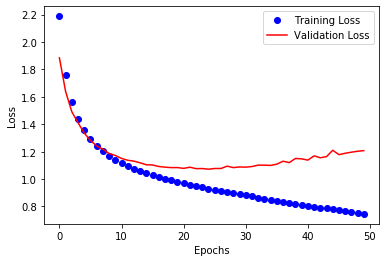

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()